<a href="https://colab.research.google.com/github/simplysumanth/Kaggle_Competitions/blob/main/Cassava_Leaf_disease_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outline of the Classification Process
- Get data from kaggle
- Preprocess the data
- Create CustomDataset
- Write the training & Valid Loop
- Inference



### Get Data from Kaggle

In [1]:
#Upload the Kaggle API key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"simplysumanth","key":"4c4d5aafd1e3c9c5586c80c0cbb778a3"}'}

In [2]:
#Configure the Kaggle 
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the dataset
#!pip install kaggle
!kaggle competitions download -c cassava-disease

So, we have now downloaded the dataset form kaggle, it has:
- train.zip -> contains 5 sub-folders, each of a class 
- test.zip -> the test data, on which the public scoreboard is scored.
- sample_submission.csv -> Sample format of how the output should be.
- extraimages.zip -> These are additional images, can be used for training.

### Preprocess the data

In [4]:
import os
import glob

In [ ]:
!unzip "train.zip" -d "/content"
!unzip "test.zip" -d "/content"

In [6]:
TRAIN_PATH = "/content/train"
TEST_PATH = "/content/test/0"

In [7]:
# Let's see how many samples are there for each class
for clas in os.listdir(TRAIN_PATH):
  print(f"The number of images in class {clas}: {len(os.listdir(TRAIN_PATH+'/'+clas))}")

The number of images in class cbb: 466
The number of images in class cgm: 773
The number of images in class cbsd: 1443
The number of images in class healthy: 316
The number of images in class cmd: 2658


Looks like there is imbalance in dataset, there are varying number of samples for each class. This might lead to a bias, where the class with more images might be most likely identified.

In [8]:
#lets create a list of the image path for train and test.
train_data, test_data = [],[]
for c in os.listdir(TRAIN_PATH):
  train_data.extend(glob.glob(os.path.join(TRAIN_PATH+"/"+c,'*.jpg')))
test_data = glob.glob(os.path.join(TEST_PATH, '*.jpg'))

In [9]:
len(train_data), len(test_data)

(5656, 3774)

In [10]:
train_data[0], test_data[0]

('/content/train/cbb/train-cbb-396.jpg', '/content/test/0/test-img-1215.jpg')

Now we have the train and test data, let's go ahead and create a custom dataset.

## Create Custom Dataset

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [12]:
class CustomDataset:
  def __init__(self,image_paths,augmentation=None):
    self.image_paths = image_paths
    self.augmentation = augmentation
  
  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    class_list = ['cbsd', 'cgm', 'cmd', 'healthy', 'cbb']
    target = self.image_paths[idx].split('-')[-2]
    if target in class_list:
      target = class_list.index(target)
    else:
      target = self.image_paths[idx].split('/')[-1] 
    image = Image.open(self.image_paths[idx])
    image = self.augmentation(image)

    return (image,target)

In [13]:
train_aug = transforms.Compose(
    [
     transforms.Resize((224,224)),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

test_aug = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])              
])


In [14]:
train_dataset = CustomDataset(train_data,train_aug)

test_dataset = CustomDataset(test_data,test_aug)


In [15]:
print(len(train_dataset))
train_dataset, valid_dataset = train_test_split(train_dataset, test_size= 0.1)
len(train_dataset) , len(valid_dataset)

5656


(5090, 566)

In [16]:
train_data_loader = DataLoader(train_dataset, batch_size= 64, shuffle= True)
valid_data_loader = DataLoader(valid_dataset, batch_size= 64, shuffle= True)
test_data_loader = DataLoader(test_dataset, batch_size = 64, shuffle=False)

In [17]:
train_data_loader, valid_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f16c70a2610>,
 <torch.utils.data.dataloader.DataLoader at 0x7f16c6f792d0>)

In [18]:
for batch_idx, data in enumerate(train_data_loader):
  if batch_idx == 5:
    break
  else:
    data,target = data
    print(data.shape)
    print(target.shape)
    break
    # print(data["image"].shape)
    # print(data["target"].shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [19]:
def show_train_data_loader(train_data_loader):
  for batch_idx, data in enumerate(train_data_loader):
    data, target = data
    img = np.transpose(data[0].numpy(), (1,2,0))
    plt.imshow(img)
    plt.title(target[0])
    break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


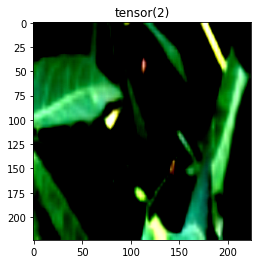

In [20]:
show_train_data_loader(train_data_loader)

## Train/Valid Loop

In [21]:
##Define a model
model = models.resnet101(pretrained=True)
for params in model.parameters():
  params.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU(),
    nn.Linear(32,5)
)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.train()

In [23]:
criterian = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [24]:
def training_valid_loop(model,criterian,optimizer,train_data_loader, valid_data_loader, epochs,device):
  for epoch in range(epochs):
    epoch_loss, epoch_accuracy = 0,0

    for data,label in train_data_loader:
      data = data.to(device)
      label = label.to(device)

      output = model(data)
      loss = criterian(output, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      accuracy = (output.argmax(dim=1) == label).float().mean()
      epoch_accuracy += accuracy/len(train_data_loader)
      epoch_loss += loss/len(train_data_loader)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))

    with torch.no_grad():
      epoch_val_accuracy, epoch_val_loss = 0,0 

      for data,label in valid_data_loader:
        data = data.to(device)
        label = label.to(device)

        val_output = model(data)
        val_loss = criterian(val_output, label)

        val_accuracy = (val_output.argmax(dim=1) == label).float().mean()
        epoch_val_accuracy += val_accuracy/len(valid_data_loader)
        epoch_val_loss += val_loss/len(valid_data_loader)
    print('Epoch : {}, Val accuracy : {}, Val loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))  

In [ ]:
training_valid_loop(model, criterian, optimizer, train_data_loader, valid_data_loader, 1, device)

In [26]:
def eval_loop(model, test_data_loader):
  model.eval()
  y_probs = []
  labels = []
  with torch.no_grad():
    for data,target in test_data_loader:
      #(batch[:-1]) -> gives out list of all the images
      #batch[-1] -> list of all labels corresponding to those images
      # batch = batch.to(device)
      # inputs, labels = batch[:-1], batch[-1]
      data = data.to(device)
      y_prob = model(data)
      y_prob_softmax = torch.nn.functional.softmax(y_prob, dim=1)
      #print(y_prob_softmax)
      y_probs.extend(int(torch.argmax(i).cpu().numpy()) for i in y_prob_softmax)
      labels.extend(target)
  return y_probs, labels

In [27]:
classes = ['cbsd', 'cgm', 'cmd', 'healthy', 'cbb']
y_probs, labels = eval_loop(model, test_data_loader)
final_list = list(map(lambda x: classes[x], y_probs))

In [28]:
import pandas as pd

In [29]:
dataframe = pd.DataFrame({"Category":final_list, "Id":labels})
dataframe.head()

,Category,Id
0,cbsd,test-img-1215.jpg
1,cbsd,test-img-3630.jpg
2,cmd,test-img-3316.jpg
3,cgm,test-img-905.jpg
4,cmd,test-img-3160.jpg


In [30]:
dataframe.to_csv("submission_resnet_101_normalized.csv",index=False)